In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import glob as gb
import calmap
from plotly_calplot import calplot

pd.set_option('display.max_columns',500)
plt.style.use('seaborn-v0_8-darkgrid')


# Read in and Format Data

In [4]:
column_subset = [
    "FlightDate",
    "Airline",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiIn",
    "TaxiOut",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    
    ]

parquet_files = gb.glob(r'C:\Users\KHADIJA\Desktop\flights data\*.parquet')
dfs = []

for f in parquet_files:
    dfs.append(pd.read_parquet(f,columns= column_subset))

if dfs:
    df = pd.concat(dfs, ignore_index=True)  
else:
    df = pd.DataFrame(columns=column_subset)



In [5]:
category_columns = ['Airline','Origin','Dest','OriginStateName','DestStateName']
for i in category_columns:
    df[i] = df[i].astype("category")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29193782 entries, 0 to 29193781
Data columns (total 21 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   FlightDate                       datetime64[us]
 1   Airline                          category      
 2   Flight_Number_Marketing_Airline  int64         
 3   Origin                           category      
 4   Dest                             category      
 5   Cancelled                        bool          
 6   Diverted                         bool          
 7   CRSDepTime                       int64         
 8   DepTime                          float64       
 9   DepDelayMinutes                  float64       
 10  OriginAirportID                  int64         
 11  OriginCityName                   object        
 12  OriginStateName                  category      
 13  DestAirportID                    int64         
 14  DestCityName                    

# Understand the DepDelayMinutes Variable

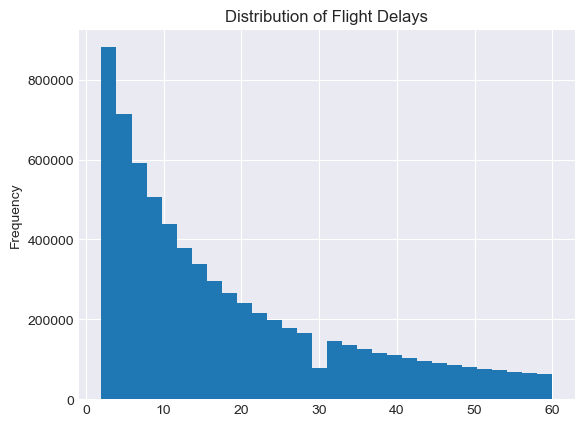

In [6]:
df.query('DepDelayMinutes > 1 and DepDelayMinutes < 61')['DepDelayMinutes'].plot(kind = 'hist', bins = 30, title="Distribution of Flight Delays")
plt.show()

# Grouping of Delay

In [7]:
df['DelayGroup'] = None
df.loc[df['DepDelayMinutes'] == 0, 'DelayGroup'] = 'OnTime_Early'
df.loc[(df['DepDelayMinutes']>0) & (df['DepDelayMinutes']<=15), 'DelayGroup'] = 'Small_Delay'
df.loc[(df['DepDelayMinutes']>15) & (df['DepDelayMinutes']<=45), 'DelayGroup'] = 'Medium_Delay'
df.loc[df['DepDelayMinutes'] > 45, 'DelayGroup'] = 'Large_Delay'
df.loc[df['Cancelled'], 'DelayGroup'] = 'Cancelled'

<Axes: title={'center': 'Flight Results'}, ylabel='DelayGroup'>

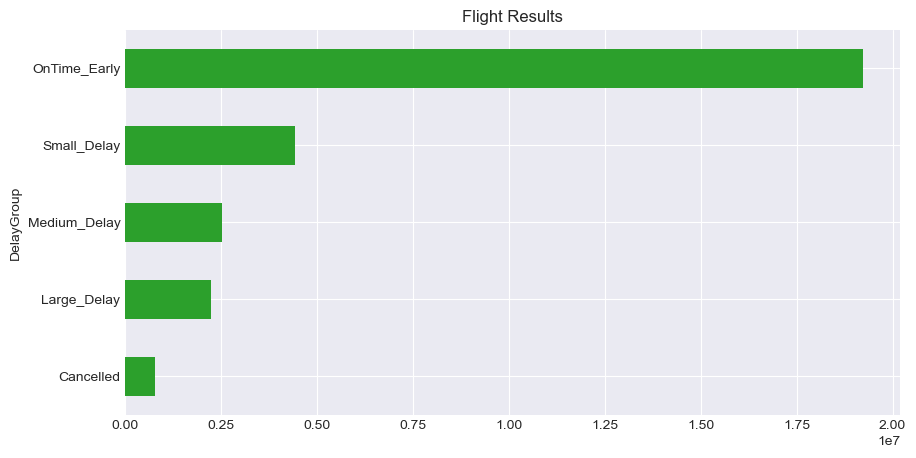

In [8]:
pal = sns.color_palette()
df['DelayGroup'].value_counts(ascending=True).plot(kind='barh', figsize = (10,5), color= pal[2], title= 'Flight Results')

In [9]:
df['Year']= df['FlightDate'].dt.year
df_temp = df.groupby('Year')['DelayGroup'].value_counts().unstack()
df_temp.style.background_gradient(cmap='Blues')


DelayGroup,Cancelled,Large_Delay,Medium_Delay,OnTime_Early,Small_Delay
Year,,,,,
2018,88373,473149,542585,3647152,937140
2019,153629,702621,734853,5228829,1271752
2020,301055,187221,229640,3819648,484833
2021,111018,472115,562885,4146782,1019071
2022,123192,389287,445619,2398098,722122


# Delay Group With Percentage 

In [10]:
df_temp = df.groupby('Year')['DelayGroup'].value_counts(normalize=True).unstack() * 100
df_temp.style.background_gradient(cmap='Greens')

DelayGroup,Cancelled,Large_Delay,Medium_Delay,OnTime_Early,Small_Delay
Year,,,,,
2018,1.553565,8.317789,9.538448,64.115615,16.474583
2019,1.898604,8.683248,9.081583,64.619787,15.716778
2020,5.994249,3.727722,4.572319,76.052291,9.653418
2021,1.758876,7.479795,8.917879,65.698142,16.145308
2022,3.020657,9.545283,10.926539,58.801153,17.706368


# How Many Flights Per Year

<Axes: title={'center': 'Scheduled Flight per Year'}, xlabel='Year'>

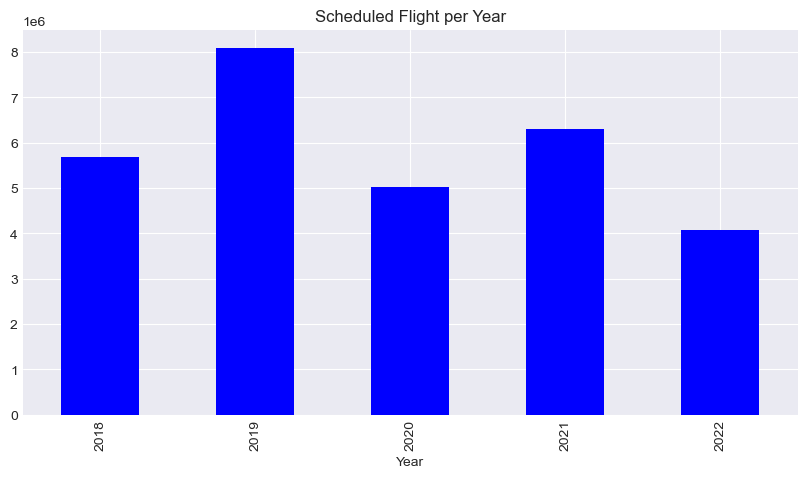

In [11]:
df['Year']= df['FlightDate'].dt.year
df['Year'].value_counts().sort_index().plot(kind='bar', figsize=(10,5) ,title='Scheduled Flight per Year', color='blue' )


# Result by Month

In [12]:
df['Month'] = df['FlightDate'].dt.month
df_temp = df.groupby('Month')['DelayGroup'].value_counts(normalize=True).unstack() * 100
col_order=['OnTime_Early','Small_Delay','Medium_Delay','Large_Delay','Cancelled']

df_temp[col_order].style.background_gradient(cmap= 'Blues')

DelayGroup,OnTime_Early,Small_Delay,Medium_Delay,Large_Delay,Cancelled
Month,,,,,
1,68.169907,13.961832,7.878093,7.008976,2.981192
2,64.960611,15.300969,8.828322,7.786858,3.123240
3,66.363322,14.172305,7.716007,6.173113,5.575252
4,64.436275,14.051844,7.824258,6.853866,6.833756
5,65.023841,16.224252,8.965554,7.875154,1.911198
6,59.488265,17.349791,10.754222,10.442093,1.965629
7,61.996702,16.361900,10.052315,9.906083,1.683000
8,64.622096,15.009025,9.096512,9.137345,2.135022
9,72.924881,13.140776,6.725733,5.813787,1.394822


In [13]:
df.query('Cancelled').groupby(['Month','Year']).size().astype('int').unstack().fillna(0).style.background_gradient()



Year,2018,2019,2020,2021,2022
Month,,,,,
1,12690.000000,19550.000000,8416.000000,4155.000000,35667.000000
2,5149.000000,18352.000000,6095.000000,20201.000000,23421.000000
3,8939.000000,13562.000000,118276.000000,5904.000000,9108.000000
4,4778.000000,15726.000000,136848.000000,2561.000000,13397.000000
5,4350.000000,14146.000000,12261.000000,2350.000000,11993.000000
6,4306.000000,14667.000000,1030.000000,9196.000000,18473.000000
7,6215.000000,14808.000000,2926.000000,10195.000000,11133.000000
8,11669.000000,12903.000000,4327.000000,18734.000000,0.000000
9,9503.000000,11045.000000,2523.000000,7776.000000,0.000000


# Cancellation Rate Heatmap by year

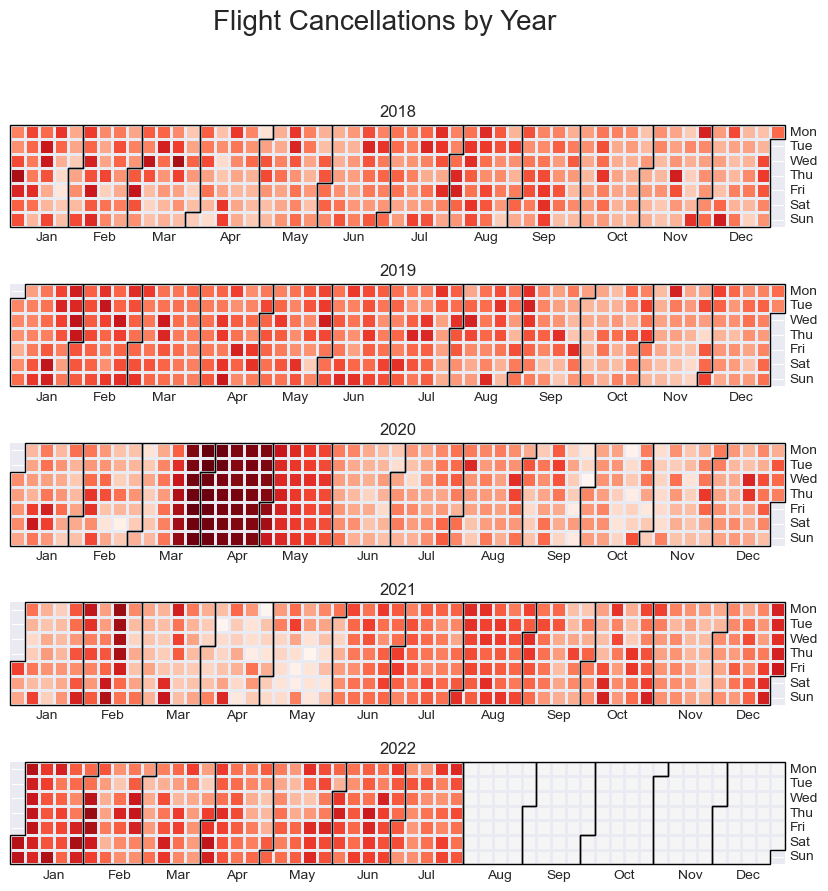

In [14]:
cancelled = df.groupby('FlightDate')['Cancelled'].mean()
fig, axs = plt.subplots(5, 1, figsize=(10, 10))  

for i, year in enumerate([2018, 2019, 2020, 2021, 2022]):
    calmap.yearplot(cancelled.apply(np.log), year=year, monthly_border=True, ax=axs[i])
    axs[i].set_title(year)

fig.suptitle('Flight Cancellations by Year', fontsize=20)
plt.show()

# Compare Airlines 

C:\Users\KHADIJA\AppData\Local\Temp\ipykernel_16976\2237464500.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  airline_delay = df.groupby('Airline')['DepDelayMinutes'].sum().sort_values(ascending=False)
C:\Users\KHADIJA\AppData\Local\Temp\ipykernel_16976\2237464500.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  airline_cancellations = df.groupby('Airline')['Cancelled'].sum().sort_values(ascending=False)


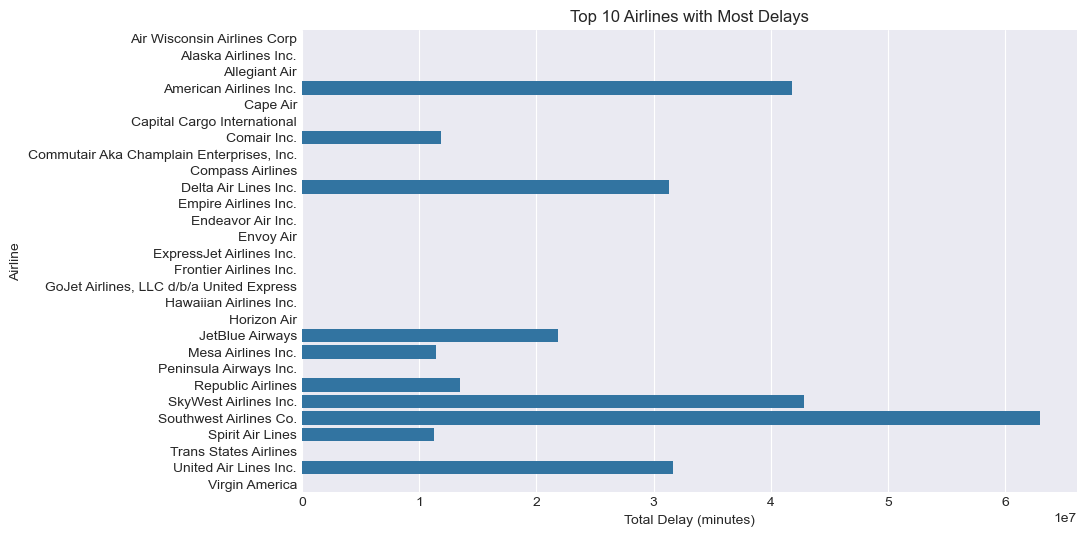

In [ ]:

airline_delay = df.groupby('Airline')['DepDelayMinutes'].sum().sort_values(ascending=False)
airline_cancellations = df.groupby('Airline')['Cancelled'].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=airline_delay.head(10).values, y=airline_delay.head(10).index, ax=ax)
plt.xlabel('Total Delay (minutes)')
plt.ylabel('Airline')
plt.title('Top 10 Airlines with Most Delays')
plt.xticks()
plt.show()



C:\Users\KHADIJA\AppData\Local\Temp\ipykernel_16976\364844644.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_cancellations.head(10).values, y=airline_cancellations.head(10).index, ax=ax, palette='Reds')


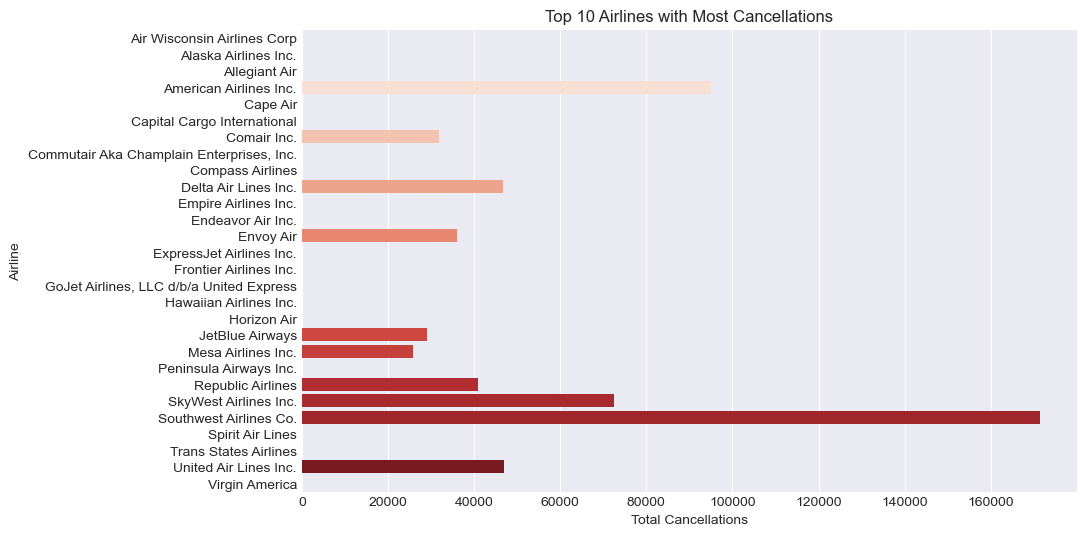

In [38]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=airline_cancellations.head(10).values, y=airline_cancellations.head(10).index, ax=ax, palette='Reds')  
plt.xlabel('Total Cancellations')
plt.ylabel('Airline')
plt.title('Top 10 Airlines with Most Cancellations')
plt.show()
